In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from PJT_Frustration_Induced_Crystallize.main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

---
# Snapshots and Phase Diagram of $\alpha$

In [256]:
phaseLags = np.linspace(0, 1, 81) * np.pi
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeeds = [6, 7, 8, 9, 10]
strengthKs = [20]
distanceD0s = [1.55]
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

lastStateSavePath = r"F:\MS_ExperimentData\lattice"
savePath = (
    f"{lastStateSavePath}/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)

data = np.load(f'{lastStateSavePath}/rho_data.npz')
totalRhoStd = data['totalRhoStd']
totalVarrhoStd = data['totalVarrhoStd']
totalPStd = data['totalPStd']

resampleStep = 1
meanRhoStd = totalRhoStd.mean(axis=0)[::resampleStep]
meanVarrhoStd = totalVarrhoStd.mean(axis=0)[::resampleStep]
meanPStd = totalPStd.mean(axis=0)[::resampleStep]
stdRhoStd = totalRhoStd.std(axis=0)[::resampleStep]
stdVarrhoStd = totalVarrhoStd.std(axis=0)[::resampleStep]
stdPStd = totalPStd.std(axis=0)[::resampleStep]
win = 1
meanRhoStd = pd.Series(meanRhoStd).rolling(win, center=True, min_periods=1).mean().values
meanVarrhoStd = pd.Series(meanVarrhoStd).rolling(win, center=True, min_periods=1).mean().values
meanPStd = pd.Series(meanPStd).rolling(win, center=True, min_periods=1).mean().values
stdRhoStd = pd.Series(stdRhoStd).rolling(win, center=True, min_periods=1).mean().values
stdVarrhoStd = pd.Series(stdVarrhoStd).rolling(win, center=True, min_periods=1).mean().values
stdPStd = pd.Series(stdPStd).rolling(win, center=True, min_periods=1).mean().values
phaseLagsX = (phaseLags / np.pi)[::resampleStep]

def calc_uniform_solution(cellNumInLine: int, cellNumInPhase: int):
    rho0 = 1 / (cellNumInLine**2 * cellNumInPhase)
    varrho0 = rho0 * cellNumInPhase
    p0 = rho0 * cellNumInLine**2
    return rho0, varrho0, p0

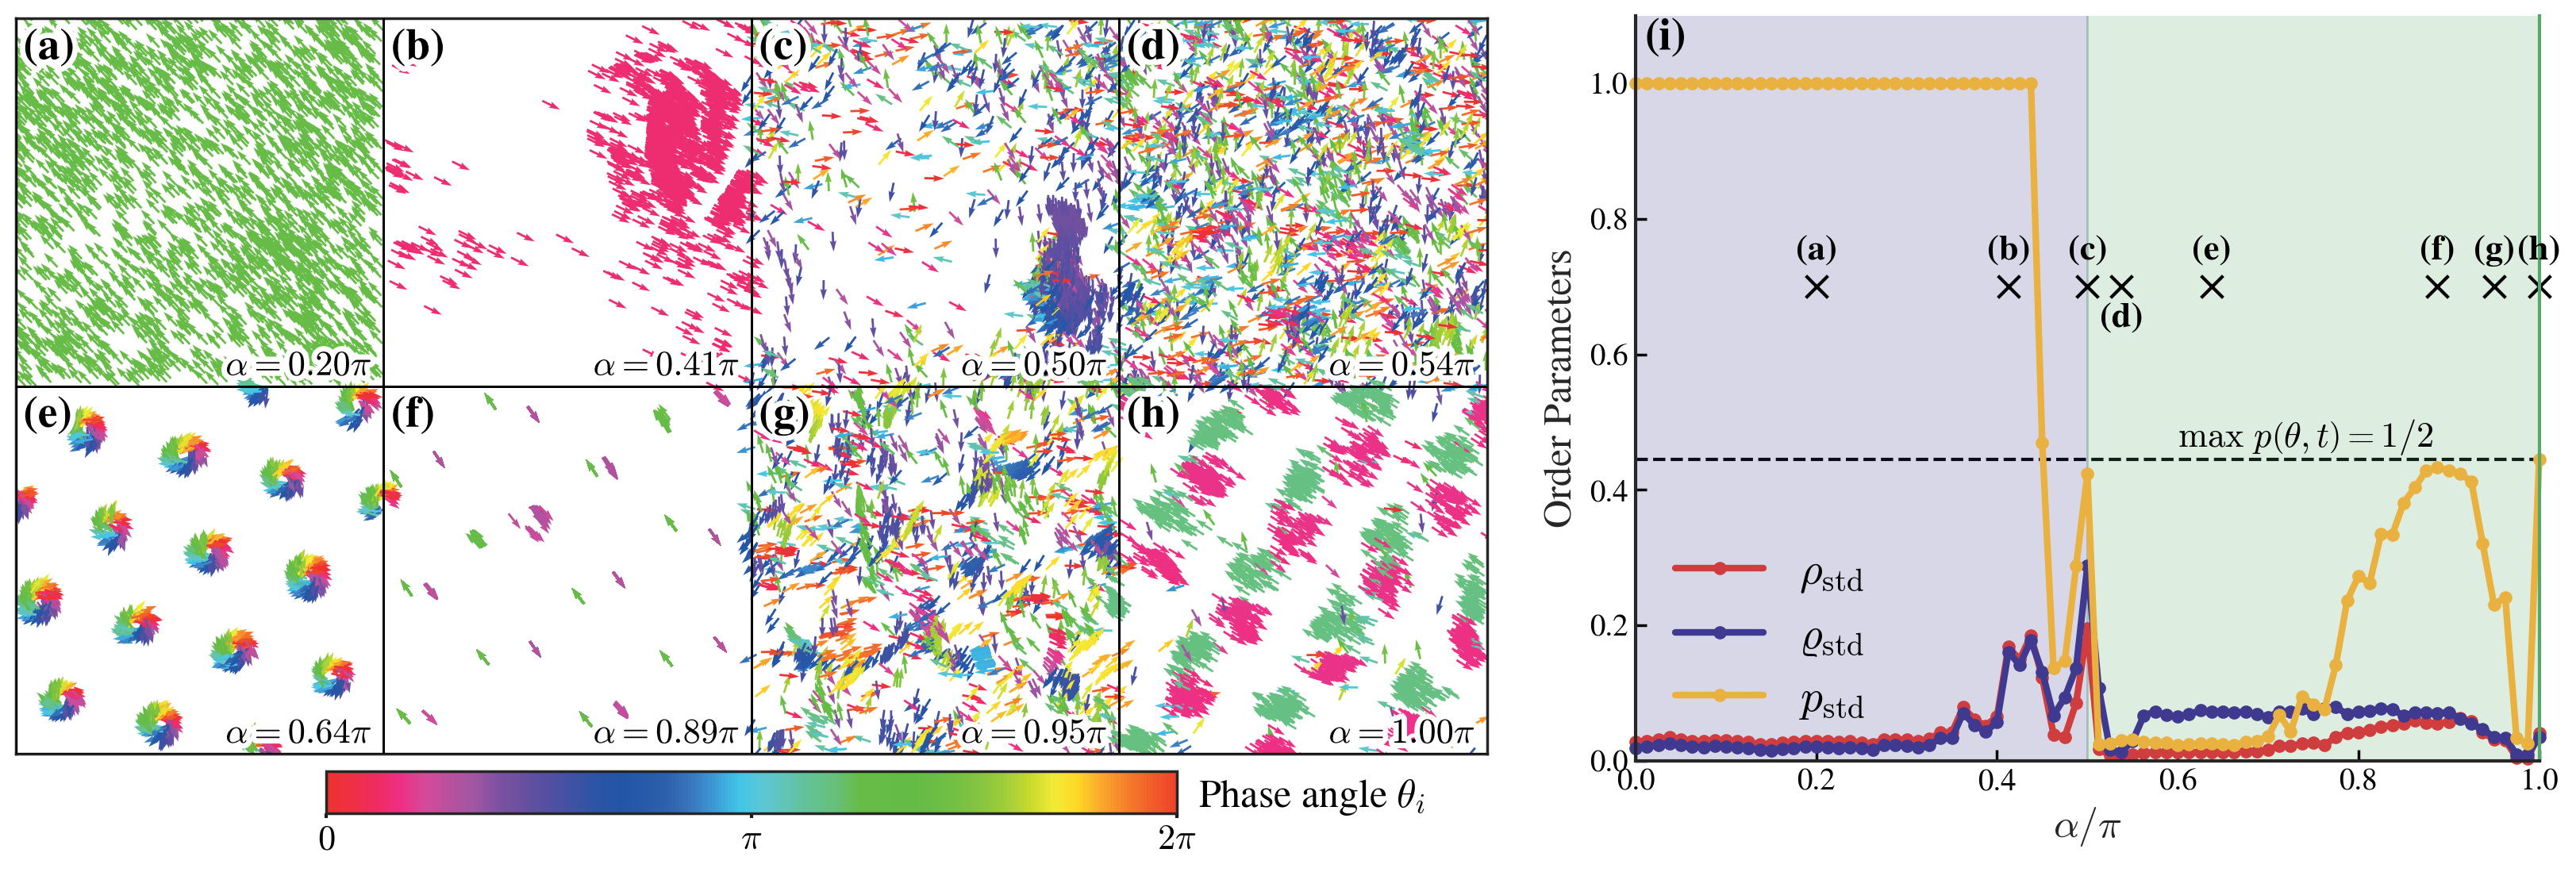

In [262]:
from matplotlib.patheffects import withStroke
from matplotlib.cm import ScalarMappable

def find_sa_by_phase_lag(sas: List[StateAnalysis], phaseLag: float) -> StateAnalysis:
    for sa in sas:
        if sa is None:
            continue
        if np.isclose(sa.model.phaseLagA0, phaseLag):
            return sa
    return None

def plot_sub_snapshots(sa: StateAnalysis, idx: int, totalRow: int, totalCol: int, 
                       ax: plt.Axes, phaseShift: float = 0):
    row, col = totalRow - 1 - idx // totalCol, idx % totalCol
    positionShift = np.array([col, row]) * sa.model.boundaryLength
    positionX, phaseTheta = sa.get_state(-1)
    phaseTheta = (phaseTheta + phaseShift) % (2 * np.pi)
    squeeze = 1
    squeezeShift = np.ones_like(positionX) * (1 - squeeze) / 2 * sa.model.boundaryLength
    positionX = positionX * squeeze + squeezeShift + positionShift
    colors = [hexCmap(i) for i in
              np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)]

    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta), np.sin(phaseTheta),
        color=colors,
        scale_units='inches', scale=8.0, width=0.0015
    )
    ax.axhline(
        y=row * sa.model.boundaryLength, color="black", 
        linewidth=1, linestyle="-", alpha=1, zorder=100
    )
    ax.axvline(
        x=col * sa.model.boundaryLength, color="black", 
        linewidth=1, linestyle="-", alpha=1, zorder=100
    )
    text1 = ax.text(0.02 * sa.model.boundaryLength + positionShift[0], 
                    0.89 * sa.model.boundaryLength + positionShift[1],
                    f"({chr(97 + idx)})", fontsize=20, fontweight="bold")
    text2 = ax.text(0.57 * sa.model.boundaryLength + positionShift[0], 
                    0.03 * sa.model.boundaryLength + positionShift[1],
                    rf"$\alpha={sa.model.phaseLagA0 / np.pi:.2f}\pi$", fontsize=16)
    for text in [text1, text2]:
        text.set_path_effects([withStroke(linewidth=5, foreground='white')])

fig, axs = plt.subplots(1, 2, figsize=(16.4, 6), gridspec_kw={"width_ratios": [12, 7.37]})
ax1: plt.Axes = axs[0]
ax2: plt.Axes = axs[1]

selectedPhaseLags = np.array([0.2000, 0.4125, 0.5, 0.5375,
                              0.6375, 0.8875, 0.95, 1.0000]) * np.pi
for idx, phaseLag in enumerate(selectedPhaseLags):
    phaseShift = 3.5 if idx == 0 else 0
    sa = find_sa_by_phase_lag(sas, phaseLag)
    plot_sub_snapshots(sa=sa, idx=idx, totalRow=2, totalCol=4, ax=ax1, phaseShift=phaseShift)
    ax2.text(
        (phaseLag / np.pi), 0.64 if idx == 3 else 0.74, 
        f"({chr(97 + idx)})", fontsize=16, fontweight="bold", ha="center"
    )
    ax2.scatter((phaseLag / np.pi), 0.7, 
                marker='x', s=100, color="black", clip_on=False)

norm = plt.Normalize(0, 2 * np.pi)
sm = ScalarMappable(cmap=hexCmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, orientation='horizontal', fraction=0.05, pad=0.02, ticks=[0, np.pi, 2*np.pi])
ax1.text(22.5, -1, r'Phase angle $\theta_i$', fontsize=18)
cbar.ax.tick_params(length=2, direction="out", color="k", width=1.5)
cbar.ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'], fontsize=16)

ax1.set_xlim(0, 4 * sa.model.boundaryLength)
ax1.set_ylim(0, 2 * sa.model.boundaryLength)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect('equal')

lw = 3
ms = 5
ax2.plot(phaseLagsX, meanRhoStd, label=r"$\rho_{\mathrm{std}}$", color="#CF3D3E", marker='o', ms=ms, lw=lw, clip_on=False)
ax2.plot(phaseLagsX, meanVarrhoStd, label=r"$\varrho_{\mathrm{std}}$", color="#403990", marker='o', ms=ms, lw=lw, clip_on=False)
ax2.plot(phaseLagsX, meanPStd, label=r"$p_{\mathrm{std}}$", color="#E9B140", marker='o', ms=ms, lw=lw, clip_on=False)
rho0, varrho0, p0 = calc_uniform_solution(cellNumInLine=10, cellNumInPhase=10)
plt.axhline(
    y=(0.5 - p0) / (1 - p0),
    color="black", linestyle="--", linewidth=1.5, alpha=1, zorder=-1,
)
plt.text(0.6, (0.5 - p0) / (1 - p0) + 0.02, r"$\max\ p\left( \theta ,t \right) =1/2$", fontsize=16)

plt.tick_params(direction='in', length=5, labelsize=14)
plt.ylabel(r"Order Parameters", fontsize=18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_color("C2")
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.xlabel(r"$\alpha / \pi$", fontsize=18)
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.legend(frameon=False, fontsize=20, loc="lower left")

# disorder
# plt.fill_betweenx([0, 1.2], 0.44, 0.5,
#                   color="#E9B140", alpha=0.2, zorder=-1)
# plt.fill_betweenx([0, 1.2], 0.92, 1,
#                   color="#E9B140", alpha=0.2, zorder=-1)
# synchronization
plt.fill_betweenx([0, 1.2], 0., 0.5,
                  color="#403990", alpha=0.2, zorder=-1)
# fix lattice
plt.fill_betweenx([0, 1.2], 0.5, 1,
                  color="C2", alpha=0.2, zorder=-1)
ax2.text(0.01, 1.05, "(i)", fontsize=20, fontweight="bold")
ax2.set_aspect(0.75)

plt.tight_layout(pad=1)
plt.savefig("figs/snapshotsAndPhaseDiagram.pdf", bbox_inches="tight")
# plt.savefig("figs/snapshotsAndPhaseDiagram.png", bbox_inches="tight")

---
# Phase Diagram of $(d_0, K)$ and Lattice constant

### For ax1-2: $\lambda$ spectrum

In [23]:
import matplotlib.ticker as ticker
from scipy.special import j1
from scipy.linalg import eig
import matplotlib.pyplot as plt

def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10, decimals: int = 5):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L0 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        if m == 1 or m == -1:
            L0[i,i] = besselTerm * np.exp(-m * alpha * 1j)
    
    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line
    
    H = L0 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    return eigenvalues[np.argsort(eigenvalues.real)].round(decimals=decimals)

def plot_continuous_spectrum(kValues: np.ndarray, params: dict, color: Any,
                             ax: plt.Axes, M: int = 10, real: bool = True):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals).max(axis=1)  # allEvals.shape == (len(kValues), 2M+1)
    if real:
        allEvals = allEvals.real
    else:
        allEvals = allEvals.imag
    ax.plot(kValues, allEvals, lw=1.5, ls="-", alpha=1, color=color)

    ax.grid(True)    
    ax.tick_params(direction='in', length=5, labelsize=14)

### For ax2: kStar

In [39]:
from matplotlib import colors as mcolors
from scipy.special import j1
from scipy.linalg import eig

def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10, decimals: int = 3):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L0 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        if m == 1 or m == -1:
            L0[i,i] = besselTerm * np.exp(-m * alpha * 1j)
    
    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line
    
    H = L0 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    return eigenvalues[np.argsort(eigenvalues.real)].round(decimals=decimals)

params = {
    'v': 3, 
    'K': 20, 
    'd0': 1.55,
}

evalsForAlpha = dict()

boundaryLength = 7
alphaPluss = np.arange(0, 0.5, 0.001)
kValues = np.arange(1, 21) * 2 * np.pi / boundaryLength

for alphaPlus in tqdm(alphaPluss):
    alpha = (0.5 + alphaPlus) * np.pi
    params["alpha"] = alpha

    boundaryLength = 7

    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M=10, decimals=5)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)
    evalsForAlpha[alpha] = allEvals

colors = ["#FFC001", "#F46F43", "#FF0000"]
posCmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)

all_stdAlpha = []
all_kValues = []
all_maxRes = []

for alpha, allEvals in evalsForAlpha.items():
    stdAlpha = alpha / np.pi
    maxRes = allEvals.real.max(axis=1)
    
    all_stdAlpha.extend(np.ones_like(maxRes) * stdAlpha)
    all_kValues.extend(kValues)
    all_maxRes.extend(maxRes)

all_stdAlpha = np.array(all_stdAlpha)
all_kValues = np.array(all_kValues)
all_maxRes = np.array(all_maxRes)


evalsForAlpha = dict()

alphaPluss = np.arange(0, 0.002, 0.00001)
kValues = np.arange(1, 21) * 2 * np.pi / boundaryLength

for alphaPlus in tqdm(alphaPluss):
    alpha = 0.5 * np.pi + alphaPlus
    params["alpha"] = alpha

    boundaryLength = 7

    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M=10, decimals=5)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)
    evalsForAlpha[alpha] = allEvals

colors = ["#FFC001", "#F46F43", "#FF0000"]
posCmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)

sub_all_stdAlpha = []
sub_all_kValues = []
sub_all_maxRes = []

for alpha, allEvals in evalsForAlpha.items():
    stdAlpha = alpha / np.pi
    maxRes = allEvals.real.max(axis=1)
    
    sub_all_stdAlpha.extend(np.ones_like(maxRes) * stdAlpha)
    sub_all_kValues.extend(kValues)
    sub_all_maxRes.extend(maxRes)

sub_all_stdAlpha = np.array(sub_all_stdAlpha)
sub_all_kValues = np.array(sub_all_kValues)
sub_all_maxRes = np.array(sub_all_maxRes)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### For ax3: Lattice constant

In [64]:
lastStateSavePath = r"F:\MS_ExperimentData\lattice"
datasAndParams = list()

phaseLags = np.array([0.6, 0.9, 1]) * np.pi  # 0.6, 0.9  # , 
boundaryLengths = [5, 7, 9]
Kd0Ranges = [
    (np.linspace(4, 20, 19), np.linspace(0.3, 1.1, 19)),
    (np.linspace(1, 20, 19), np.linspace(0.1, 3, 19))
]

for boundaryLength, phaseLag in product(boundaryLengths, phaseLags):
    firstBreakKs, edgeDistances = dict(), dict()
    for Kd0Range in Kd0Ranges:
        strengthKs, distanceD0s = Kd0Range
        models = [
            PhaseLagPatternFormation(
                strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
                boundaryLength=boundaryLength,
                freqDist="uniform", initPhaseTheta=None,
                omegaMin=0, deltaOmega=0, 
                agentsNum=2000, dt=0.005,
                tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
                randomSeed=10, overWrite=False
            )
            for strengthK in strengthKs
            for distanceD0 in distanceD0s
        ]
        savePath = (
            f"{lastStateSavePath}/LatticeConstant_{models[0].__class__.__name__}_"
            f"{models[0].freqDist}_"
            f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
            f"phaseLagA0{models[0].phaseLagA0:.3f}_"
            f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
            f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
            f"bL{models[0].boundaryLength}_"
            f"lastState.pkl"
        )
        if not os.path.exists(savePath):
            continue

        with open(savePath, "rb") as f:
            subFirstBreakKs, subEdgeDistances = pickle.load(f)
        
        firstBreakKs.update(subFirstBreakKs)
        edgeDistances.update(subEdgeDistances)

    if len(firstBreakKs) == 0:
        continue

    datasAndParams.append([firstBreakKs, edgeDistances, (boundaryLength, phaseLag)])

### Draw!

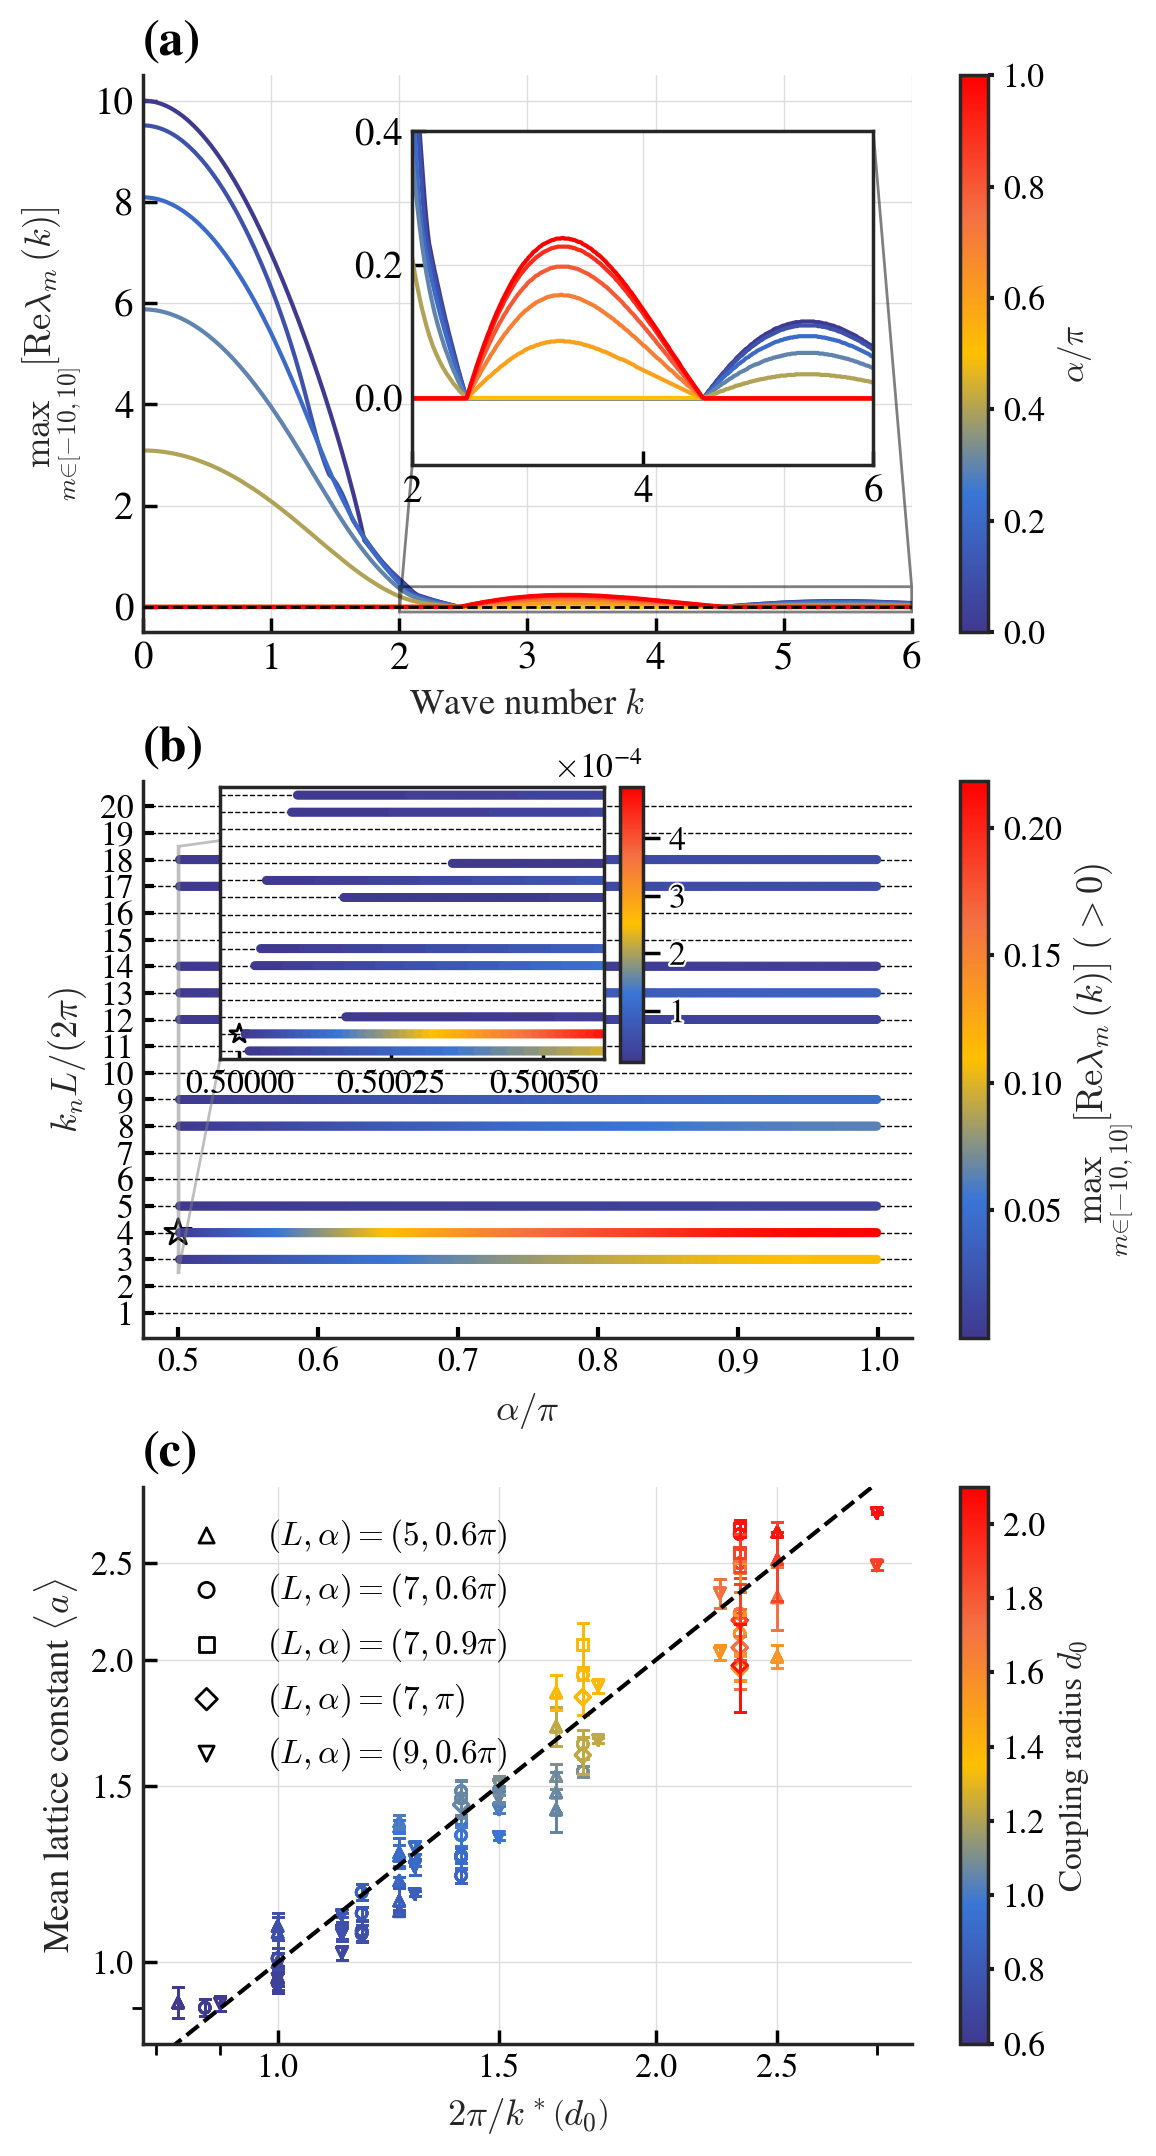

In [69]:
import matplotlib.patheffects as path_effects
import matplotlib.ticker as ticker
from matplotlib import gridspec
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(6, 11))

ax1 = fig.add_subplot(gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])[0])
ax2 = fig.add_subplot(gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])[1])
ax3 = fig.add_subplot(gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])[2])

# == eigenvalue vs k ================================================================
axTide1 = ax1.inset_axes([0.35, 0.3, 0.6, 0.6])
ax1KValues = np.linspace(0.01, 6, 500)  # np.arange(1, 100) * 2 * np.pi / 7
multipers = np.linspace(0, 1, 11)
for multiper in multipers:
    plot_continuous_spectrum(ax1KValues, {'v': 3, 'K': 20, 'd0': 1.55, "alpha": np.pi * multiper}, 
                             color=cmap(multiper), ax=ax1, M=10)
    plot_continuous_spectrum(ax1KValues, {'v': 3, 'K': 20, 'd0': 1.55, "alpha": np.pi * multiper}, 
                             color=cmap(multiper), ax=axTide1, M=10)
ax1.set_ylabel(r"$\max_{m\in \left[ -10,10 \right]} [\mathrm{Re} \lambda _m(k)]$")
ax1.set_xlabel(r"Wave number $k$")
ax1.axhline(0, color="black", lw=1, zorder=100, ls="--")
ax1.set_xlim(0, 6)
axTide1.set_xlim(2, 6)
axTide1.set_ylim(-0.1, 0.4)
ax1.indicate_inset_zoom(axTide1, edgecolor='black')

norm = plt.Normalize(0, 1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax1)
cbar1.set_label(r'$\alpha/\pi$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

# == wavenumber vs alpha ============================================================
mask_neg = all_maxRes <= 0
for i in range(1, len(kValues) + 1):
    ax2.axhline(y=i, color='black', linestyle='--', linewidth=0.5, zorder=0)
ax2.scatter(0.5, 4, marker='*', s=100, facecolors='none', edgecolors='black', zorder=0)

ax2boundaryLength = 7
sc2 = ax2.scatter(all_stdAlpha[~mask_neg], all_kValues[~mask_neg] / (2 * np.pi / ax2boundaryLength), 
                 s=5, c=all_maxRes[~mask_neg], cmap=cmap)

cbar2 = fig.colorbar(sc2)
cbar2.set_label(label=r'$\max_{m\in \left[ -10,10 \right]} [\mathrm{Re} \lambda _m(k)]\ (>0)$')
cbar2.ax.tick_params(length=2, direction="out", color="k", width=1.5)
cbar2.formatter = ticker.FuncFormatter(lambda x, _: f"{x:.2f}")
cbar2.update_ticks()

ax2.ticklabel_format(axis='x', style='sci')

ax2.set_xlabel(r'$\alpha / \pi$')
ax2.set_ylabel(r"$k_n L / (2\pi)$")
ax2.set_yticks(np.arange(1, len(kValues) + 1))
ax2.tick_params(direction='in', length=4, width=1.5)

axTide = ax2.inset_axes([0.1, 0.5, 0.5, 0.49])

for i in range(1, len(kValues) + 1):
    axTide.axhline(y=i, color='black', linestyle='--', linewidth=0.5, zorder=0)
axTide.scatter(0.5, 4, marker='*', s=50, facecolors='none', edgecolors='black', zorder=0)

sub_mask_neg = sub_all_maxRes <= 0
sc = axTide.scatter(sub_all_stdAlpha[~sub_mask_neg], 
                    sub_all_kValues[~sub_mask_neg] / (2 * np.pi / ax2boundaryLength), 
                 s=5, c=sub_all_maxRes[~sub_mask_neg], cmap=cmap)

axTide.set_xlim(None, 0.5006)
axTide.set_ylim(2.5, 18.5)
axTide.set_yticks([])
axTide.tick_params(length=3, direction="in")

ax2.indicate_inset_zoom(axTide, linewidth=1)

# == lattice consttants ============================================================
minD0, maxD0 = 0.6, 2.1
speedV = 3

markers = ['^', 'o', 's', 'D', 'v']

for gIdx, (firstBreakKs, edgeDistances, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params

    KsAndD0s = np.array(list(firstBreakKs.keys()))
    selectKs, selectD0s = KsAndD0s[:, 0], KsAndD0s[:, 1]
    selectKs = selectKs[14 < selectKs]
    if phaseLagA0 < np.pi:
        selectD0s = selectD0s[(minD0 < selectD0s) & (selectD0s <= maxD0)]  # & 
    else:
        selectD0s = selectD0s[(1 < selectD0s) & (selectD0s <= maxD0)]

    totalKStars = list()
    totalMeanEdgeDistances = list()

    for i, d0 in enumerate(selectD0s):
        kStars = list()
        meanEdgeDistances = list()

        for K in KsAndD0s[KsAndD0s[:, 1] == d0, 0]:
            firstPosK = firstBreakKs[(K, d0)]
            edgeDistance = edgeDistances[(K, d0)][0]
            adjust = 0
            meanEdgeDistance = np.mean(edgeDistance)
            kStars.append(2 * np.pi / firstPosK)
            meanEdgeDistances.append(meanEdgeDistance)

        meanEdgeDistances, stdEdgeDistance = np.mean(meanEdgeDistances), np.std(meanEdgeDistances)
        meanKstars, stdKstars = np.mean(kStars), np.std(kStars)

        color = cmap((d0 - minD0) / (maxD0 - minD0))
        ax3.scatter(
            meanKstars + adjust, meanEdgeDistances,
            s=15, alpha=1, marker=markers[gIdx],
            facecolors="none", edgecolors=color
        )
        ax3.errorbar(meanKstars + adjust, meanEdgeDistances, 
                     xerr=stdKstars, yerr=stdEdgeDistance,
                     color="none", ecolor=color, capsize=2, alpha=1, lw=1)
        totalKStars += kStars
        totalMeanEdgeDistances += meanEdgeDistances

ax3.tick_params(length=5, direction="in")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.grid()
ax3.set_xlabel(r"$2\pi /k^*\left( d_0 \right)$")
ax3.set_ylabel(r"Mean lattice constant $\langle a\rangle$")

ax3.semilogx()
ax3.semilogy()

ax3.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax3.xaxis.set_minor_formatter(ticker.NullFormatter())
ax3.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax3.yaxis.set_minor_formatter(ticker.NullFormatter())

ax3.set_xticks([1, 1.5, 2, 2.5])
ax3.set_yticks([1, 1.5, 2, 2.5])

norm = plt.Normalize(minD0, maxD0)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar3 = plt.colorbar(sm, ax=ax3)
cbar3.set_label(r'Coupling radius $d_0$', fontsize=12)
cbar3.ax.tick_params(length=2, direction="out", color="k", width=1.5)

ax3.set_xlim(ax3.get_xlim()[0], ax3.get_xlim()[1])
ax3.set_ylim(ax3.get_ylim()[0], ax3.get_ylim()[1])

for gIdx, (_, _, params) in enumerate(datasAndParams):
    boundaryLength, phaseLagA0 = params
    if phaseLagA0 < np.pi:
        ax3.scatter([], [], s=30, alpha=1, marker=markers[gIdx],
                    facecolors="none", edgecolors="black",
                    label=rf"$(L, \alpha)=({boundaryLength}, {phaseLagA0/np.pi:.1f}\pi)$")
    else:
        ax3.scatter([], [], s=30, alpha=1, marker=markers[gIdx],
            facecolors="none", edgecolors="black",
            label=rf"$(L, \alpha)=({boundaryLength}, \pi)$")

slope, intercept = 1, 0
xs = np.array([0.7, 3.5])
ax3.plot(xs, 
         slope * xs + intercept,
         color="black", linestyle="--", linewidth=1.5)
    
ax3.legend(frameon=False, fontsize=12, ncol=1, loc="upper left")

for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(f"({chr(97 + i)})", fontsize=18, fontweight="bold",
                  va='top', ha='left', loc='left', pad=20)

plt.tight_layout(h_pad=-0.1)

cax = ax2.inset_axes([0.62, 0.495, 0.03, 0.495])  # [left, bottom, width, height]
tideCbar = fig.colorbar(sc, cax=cax, ticks=[0.0001, 0.0002, 0.0003, 0.0004])
tideCbar.formatter = ticker.ScalarFormatter(useMathText=True) 
tideCbar.formatter.set_powerlimits((-3, 4))
for label in tideCbar.ax.get_yticklabels():
    label.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='white'),
        path_effects.Normal()
    ])

plt.savefig("figs/eigenvaluesAndLatticeConstants.pdf", bbox_inches="tight")
plt.show()

---


### For ax1-3: Phase Diagram

In [72]:
from matplotlib.patheffects import withStroke

with open("criticalThres.pkl", "rb") as f:
    criticalKs, criticalD0s = pickle.load(f)


def draw_snapshot_phase_diagram(phaseLag: float, strengthKs: np.ndarray, distanceD0s: np.ndarray, 
                                ax: plt.Axes, savePath: str, longLabel: bool):

    models = [
        PhaseLagPatternFormation(
            strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
            boundaryLength=7, speedV=3,
            freqDist="uniform", initPhaseTheta=None,
            omegaMin=0, deltaOmega=0, 
            agentsNum=2000, dt=0.005,
            tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
            randomSeed=randomSeed, overWrite=False
        )
        for strengthK in strengthKs
        for distanceD0 in distanceD0s
    ]
    savePath = (
        f"{savePath}/{models[0].__class__.__name__}_"
        f"{models[0].freqDist}_"
        f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
        f"phaseLagA0{models[0].phaseLagA0:.3f}_"
        f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
        f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
        f"bL{models[0].boundaryLength}_"
        f"lastState.h5"
    )
    modelsNum = len(models)

    sas = list()
    allPositionX = pd.read_hdf(savePath, key="positionX")
    allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
    allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
    allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

    for i, model in enumerate(models):
        sa = StateAnalysis()
        sa.model = model
        sa.totalPositionX = np.array([allPositionX[i]])
        sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
        sas.append(sa)
    
    distanceD0s = np.linspace(0.1, 3, 19)
    distanceD0s = distanceD0s[distanceD0s < 2.1]
    distanceD0s = distanceD0s[np.linspace(0, len(distanceD0s)-1, 5).round().astype(int)]
    strengthKs = strengthKs[np.linspace(0, len(strengthKs)-1, 5).round().astype(int)]

    colParams = distanceD0s
    rowParams = strengthKs

    for i in range(len(colParams) * len(rowParams)):
        row = i // len(rowParams)
        col = i % len(rowParams)
        # print(f"Searching for model at K={rowParams[row]}, d0={colParams[col]}")
        # print(type(rowParams[row]), type(colParams[col]))
        findModels = [sa for sa in sas 
            if (np.round(sa.model.strengthK, 3) == np.round(rowParams[row], 3)) and
               (np.round(sa.model.distanceD0, 3) == np.round(colParams[col], 3))]
        if len(findModels) == 0:
            assert False, f"Not found model for K={rowParams[row]}, d0={colParams[col]}"
        sa: StateAnalysis = findModels[0]
        
        positionShift = np.array([row, col]) * sa.model.boundaryLength
        positionX, phaseTheta = sa.get_state(-1)
        positionX = positionX + positionShift
        colors = [hexCmap(i) for i in
              np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)]

        ax.quiver(
            positionX[:, 0], positionX[:, 1],
            np.cos(phaseTheta), np.sin(phaseTheta), 
            color=colors,
            # scale=300, width=0.0004 / len(rowParams) * 7
            scale_units='inches', scale=35.0, width=0.001
        )
        ax.axhline(
            y=col * sa.model.boundaryLength, 
            color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
        )
        ax.axvline(
            x=row * sa.model.boundaryLength, 
            color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
        )

    boundaryLength = models[0].boundaryLength
    ax.set_xlim(0, len(rowParams) * boundaryLength)
    ax.set_ylim(0, len(colParams) * boundaryLength)
    ax.set_xticks(
        np.arange(0, len(rowParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
        [f"{k:.1f}" for k in rowParams]
    )
    ax.set_yticks(
        np.arange(0, len(colParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
        [f"{d:.1f}" for d in colParams]
    )

    if longLabel:
        text1 = ax.text(len(rowParams) * boundaryLength * 0.77, len(rowParams) * boundaryLength * 0.06,
                        "Coupling strength $K$", # weight="bold",
                        fontsize=12, ha="center", va="center")
        text2 = ax.text(len(rowParams) * boundaryLength * 0.06, len(rowParams) * boundaryLength * 0.77,
                        "Coupling radius $d_0$", # weight="bold",
                        fontsize=12, ha="center", va="center", rotation=90)
    else:
        text1 = ax.text(len(rowParams) * boundaryLength * 0.95, len(rowParams) * boundaryLength * 0.06,
                        "$K$", # weight="bold",
                        fontsize=12, ha="center", va="center")
        text2 = ax.text(len(rowParams) * boundaryLength * 0.06, len(rowParams) * boundaryLength * 0.95,
                        "$d_0$", # weight="bold",
                        fontsize=12, ha="center", va="center", rotation=90)
    for text in [text1, text2]:
        text.set_path_effects([withStroke(linewidth=3, foreground='white')])

    ax.text(2.5 * sa.model.boundaryLength, 5.16 * sa.model.boundaryLength,
            rf"$\alpha={phaseLag / np.pi:.1f}\pi$", fontsize=14, ha="center", va="center")

    ax.tick_params(length=5, direction="in")
    ax.set_aspect('equal')

    counts = len(strengthKs)
    ax.plot(criticalKs / (strengthKs.max() - strengthKs.min()) * counts * sa.model.boundaryLength,
            criticalD0s / (distanceD0s.max() - distanceD0s.min()) * counts * sa.model.boundaryLength,
            lw=1.5, color="black", linestyle="--")

### For ax4-5: Respiration motion

In [ ]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    omegaMin=0, deltaOmega=0,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

In [124]:
def plot_tv_snapshots(sa: StateAnalysis, ax: plt.Axes, timesIdx: List[int],
                      xlim: Tuple[float, float], ylim: Tuple[float, float]):
    analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

    classes, centers = sa.calc_classes_and_centers(classDistance=analysisRadius, lookIdx=-1)
    if len(classes) > model.agentsNum * 0.2:
        # print(f"Too many classes: {len(classes)} > {model.agentsNum * 0.2}, skipping.")
        return [], []
    numInClasses = np.array([len(c) for c in classes])
    # zScoreNum = stats.zscore(numInClasses)
    # classes = [classes[c] for c in range(len(classes)) 
    #            if (zScoreNum[c] > -0.4) and (numInClasses[c] > 10)]
    numThres = np.median(numInClasses[numInClasses > 10]) * 0.
    classes = [classes[c] for c in range(len(classes))
                if (numInClasses[c] > max(numThres, 10))]
    centers = np.mod(centers, model.boundaryLength)
    if len(classes) <= 1:
        # print("Not enough classes, skipping.")
        return [], []

    classCenters: List[np.ndarray] = []
    for c in classes:
        singleClassCenters = centers[c]

        maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
        subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
        maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
        subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

        singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
        classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
        classCenters.append(classCenter)
    classCenters: np.ndarray = np.array(classCenters)

    # edges, ajdClassCenters = sa.calc_nearby_edges(
    #     classCenters=classCenters, 
    #     stdMulti=0.3,
    #     relativeDistance=False
    # )

    # classAnalRadius = list()

    # for _, oscIdx in enumerate(classes):
    #     freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]
    #     meanFreq = freqOmega.mean()
    #     analRadius = model.speedV / np.abs(meanFreq - model.strengthK * np.sin(model.phaseLagA0))
        
    #     classAnalRadius.append(analRadius)

    # classAnalRadius = np.array(classAnalRadius)
    # edgeDistances = np.array([
    #     sa.calc_replative_distance(ajdClassCenters[edge[0]], ajdClassCenters[edge[1]]) 
    #     for edge in edges
    # ])
    selectedCenters = list()
    for classCenter in classCenters:
        if classCenter[0] < xlim[0] or classCenter[0] > xlim[1]:
            continue
        if classCenter[1] < ylim[0] or classCenter[1] > ylim[1]:
            continue
        selectedCenters.append(classCenter)

    for idx, timeIdx in enumerate(timesIdx):
        positionX, phaseTheta = sa.get_state(timeIdx)
        limWhere = np.where(
            (positionX[:, 0] >= xlim[0]) & (positionX[:, 0] <= xlim[1]) &
            (positionX[:, 1] >= ylim[0]) & (positionX[:, 1] <= ylim[1])
        )
        positionX = positionX[limWhere]
        phaseTheta = phaseTheta[limWhere]

        positionShift = np.array([idx, 0]) * (xlim[1] - xlim[0])
        squeeze = 1
        squeezeShift = np.ones_like(positionX) * (1 - squeeze) / 2 * (xlim[1] - xlim[0])
        positionX = positionX * squeeze + squeezeShift + positionShift
        colors = [hexCmap(i) for i in
                  np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)]

        ax.quiver(
            positionX[:, 0], positionX[:, 1],
            np.cos(phaseTheta), np.sin(phaseTheta),
            color=colors,
            scale_units='inches', scale=8.0, width=0.0015
        )
        ax.axvline(
            x=xlim[0] + idx * (xlim[1] - xlim[0]), color="black",
            linewidth=1, linestyle="-", alpha=1, zorder=100
        )
        # for edge in edges:
        #     ax.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
        #             color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
        for classCenter in selectedCenters:
            ax.add_artist(plt.Circle(classCenter * squeeze + positionShift, analysisRadius, alpha=0.3, ls="--",
                                     edgecolor="black", facecolor="none"))

    ax.set_xlim(xlim[0], xlim[0] + len(timesIdx) * (xlim[1] - xlim[0]))
    ax.set_ylim(ylim)

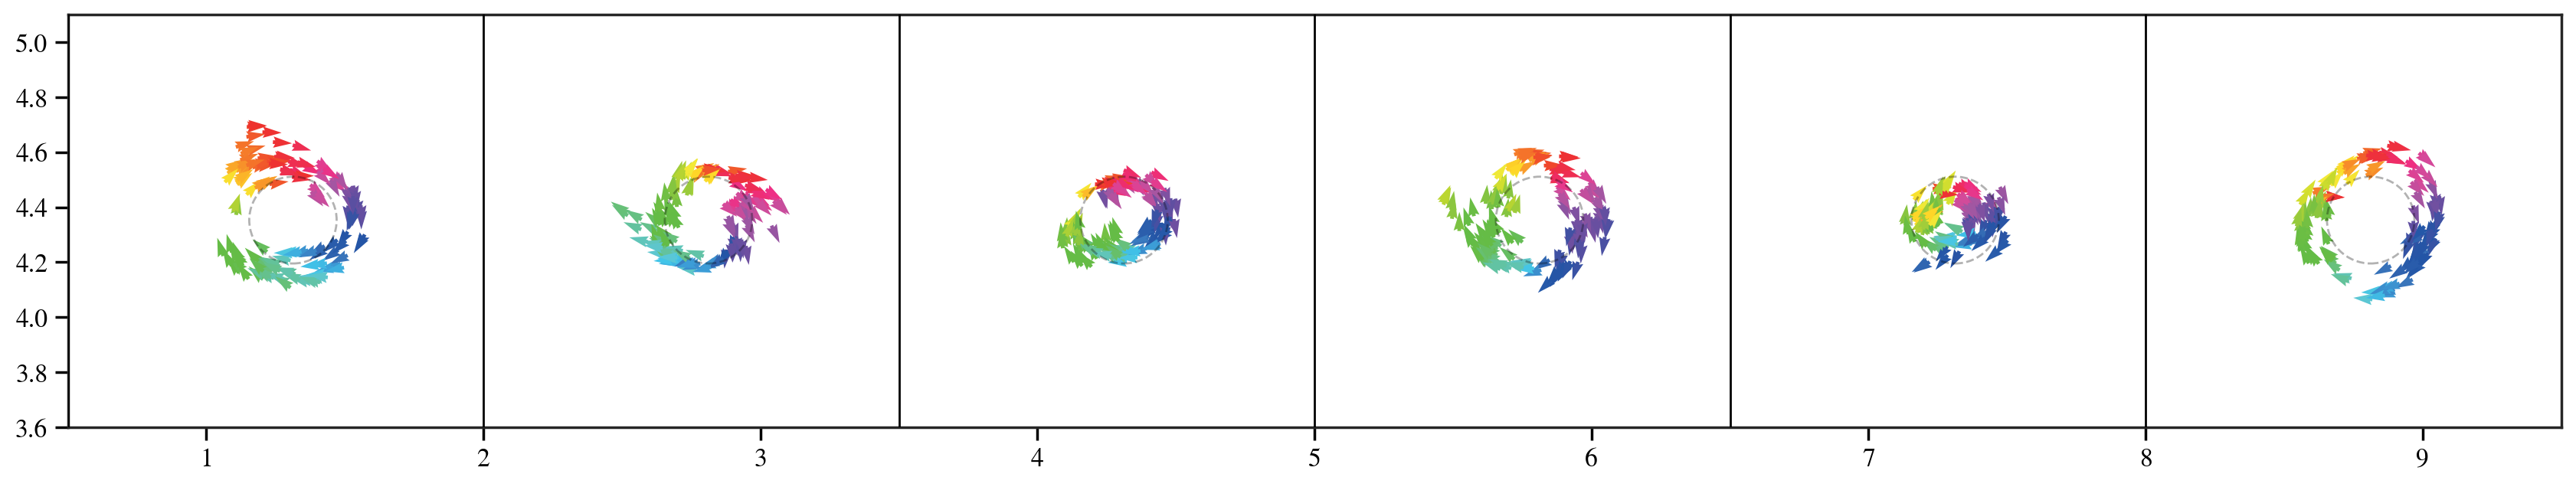

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(3.5 * 6, 3.5))
wide, xlimL, ylimL = 1.5, 0.5, 3.6
plot_tv_snapshots(sa=sa, ax=ax, timesIdx=[-500, -400, -300, -200, -100, -1], 
                  xlim=(xlimL, xlimL + wide), ylim=(ylimL, ylimL + wide))

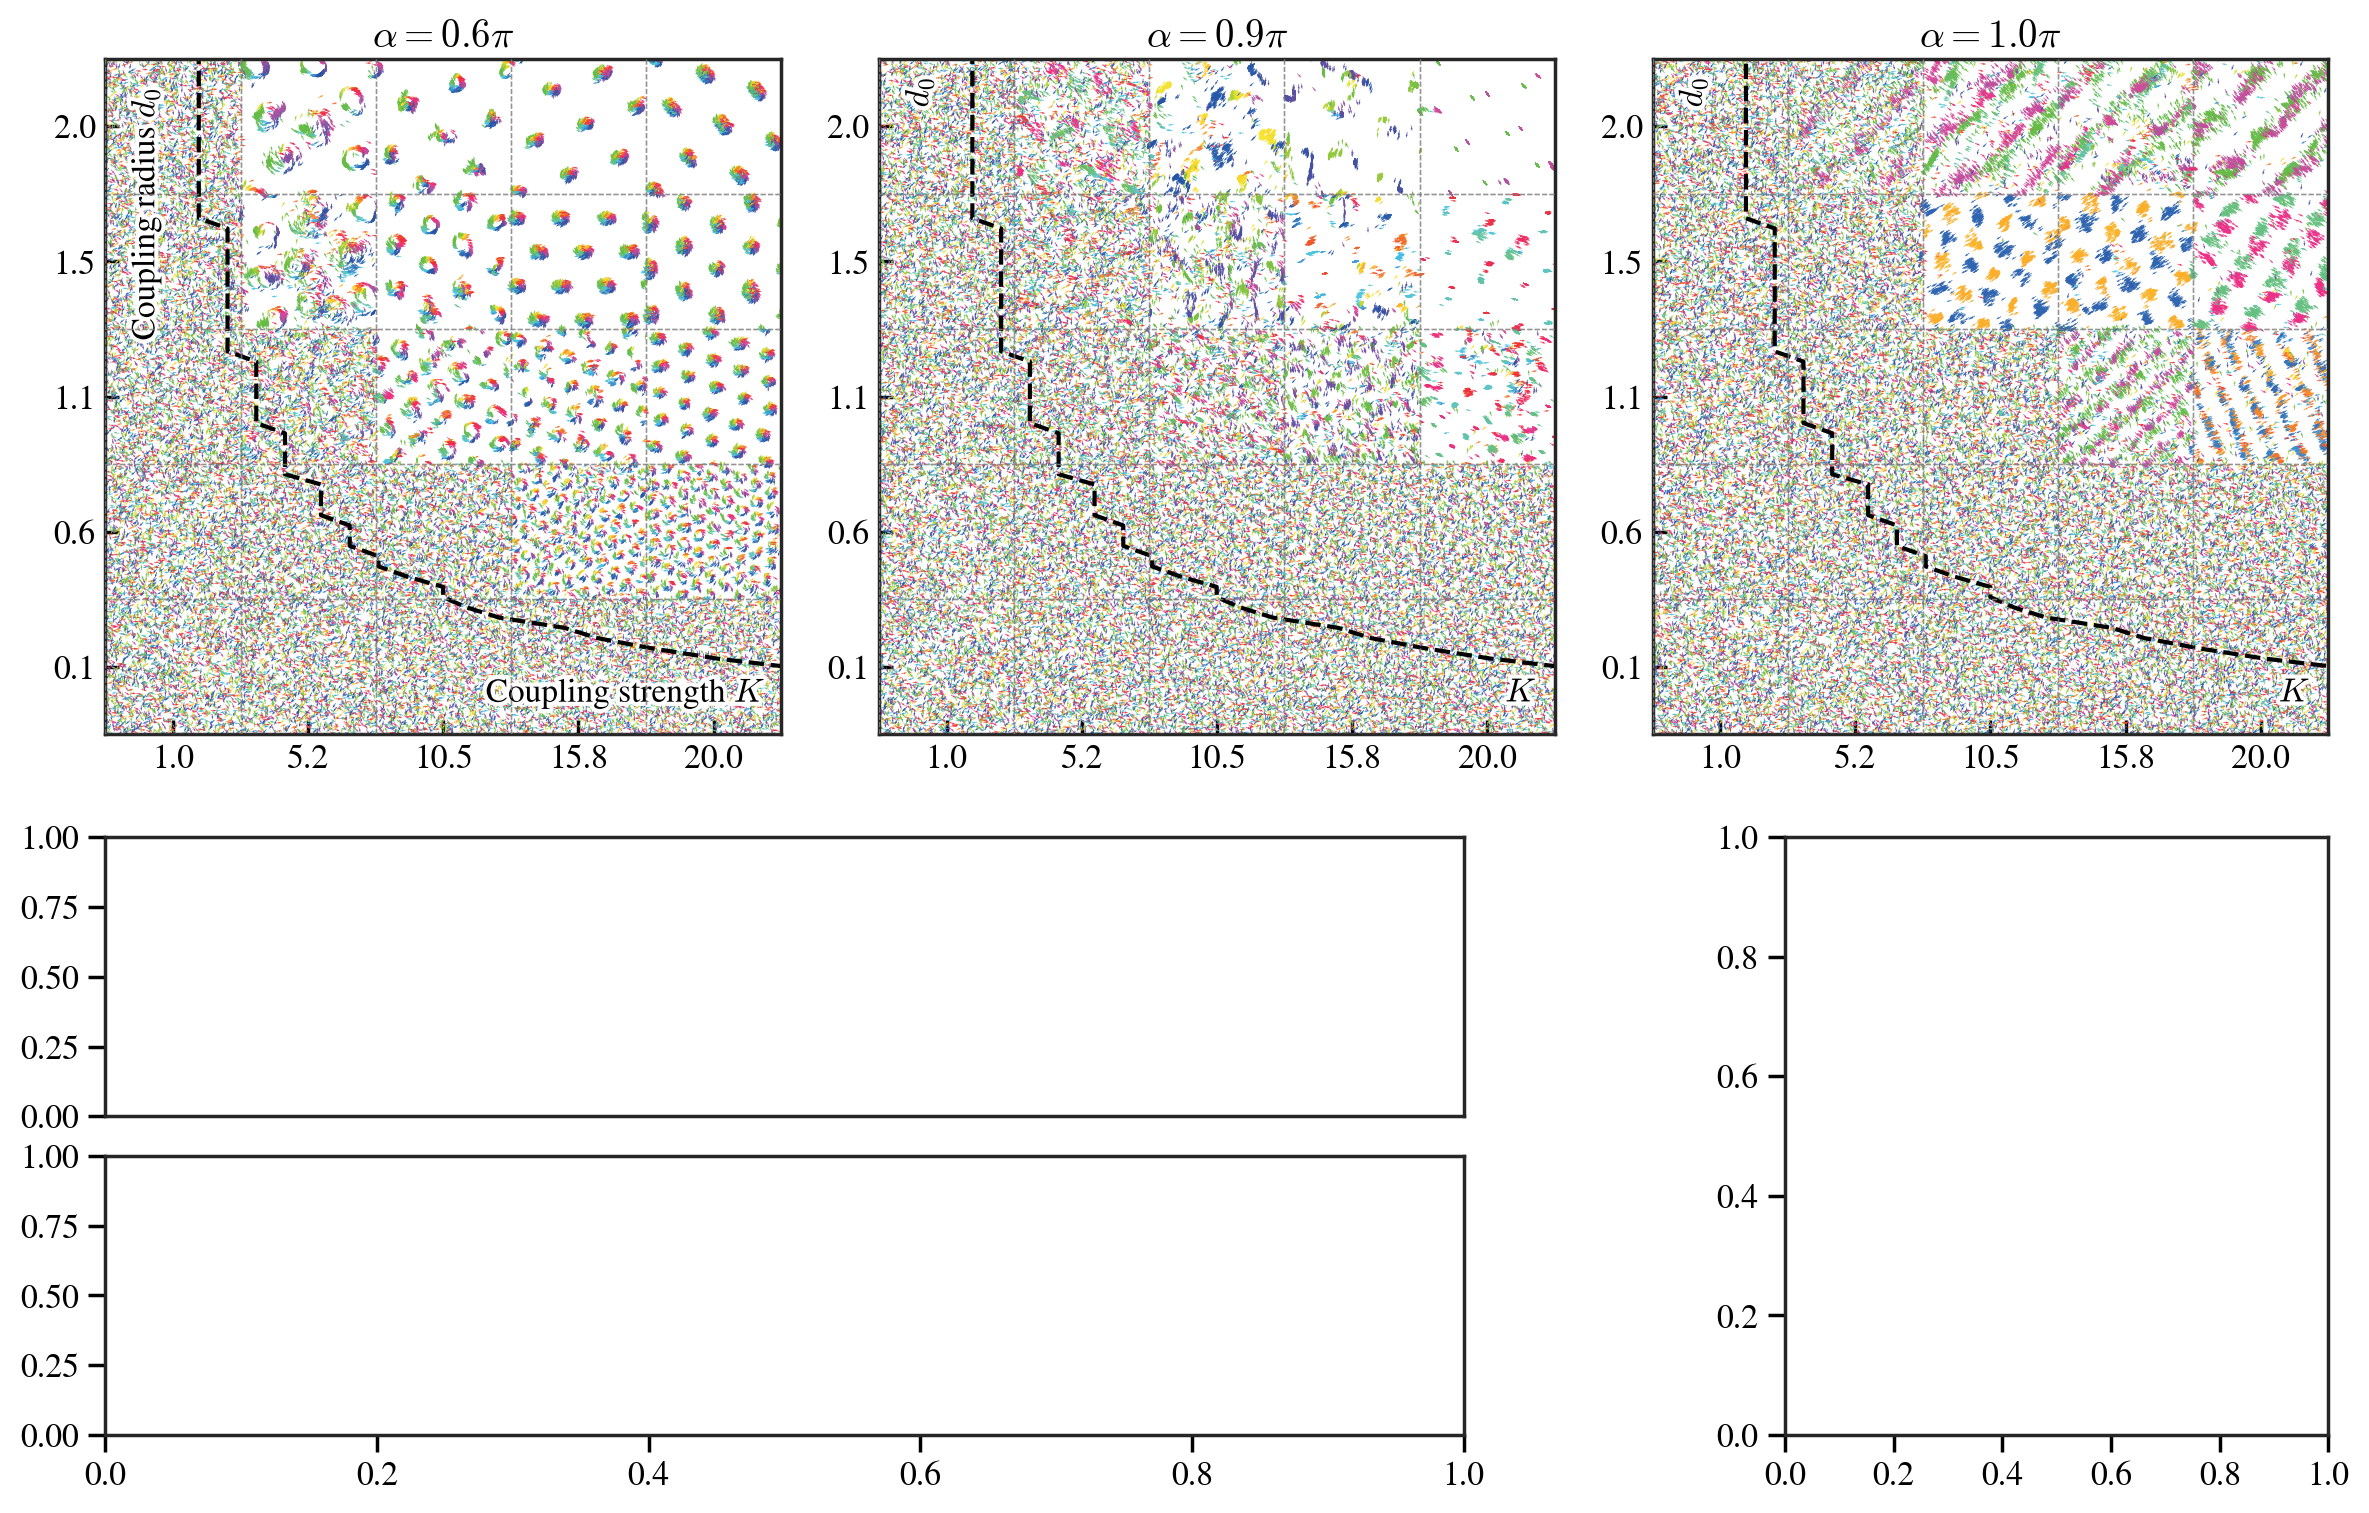

In [ ]:
import matplotlib.patheffects as path_effects
import matplotlib.ticker as ticker
from matplotlib import gridspec
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(12, 6 / 2 * 2.6))

gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 1], height_ratios=[1.4, 1.2])

ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[0, 4:6])

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1, :], width_ratios=[2.5, 1])

gs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs2[0])
ax4 = plt.subplot(gs3[0])
ax5 = plt.subplot(gs3[1])
ax6 = plt.subplot(gs2[1])

lastStateSavePath = r"F:\MS_ExperimentData\lattice"
draw_snapshot_phase_diagram(0.6 * np.pi, np.linspace(1, 20, 19), np.linspace(0.1, 3, 19), 
                            ax1, lastStateSavePath, longLabel=True)
draw_snapshot_phase_diagram(0.9 * np.pi, np.linspace(1, 20, 19), np.linspace(0.1, 3, 19), 
                            ax2, lastStateSavePath, longLabel=False)
draw_snapshot_phase_diagram(np.pi, np.linspace(1, 20, 19), np.linspace(0.1, 3, 19), 
                            ax3, lastStateSavePath, longLabel=False)

ax4.set_xticks([])

plt.tight_layout()